# 对单摆问题的一般性讨论——三维单摆的模型研究 3-D Pendulum Discussion

In [6]:
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time
plt.style.use('bmh')
figsize = (12, 5)
dpi = 600

## *首先对上一篇文章最后给出的模型进行修改和完善——1D Model Modification*

之前在建立广义一维振动的过程中，我们发现函数中有重复且不必要的内容  
```python
    #带入求和函数
    def LdB(self,A, B, t):
        C=self.C
        dB = np.sum(self.LC(A,B,t))
        return dB
   #带入系数函数
    def LC(self, A ,B ,t):
        C=self.C
        _LA = C[0][0]*A**2 + C[0][1]*A +C[0][2]
        _LB = C[1][0]*B**2 + C[1][1]*B +C[1][2]
        _Lt = C[2][0]*t**2 + C[2][1]*t +C[2][2]
        L  = [_LA , _LB, _Lt] 
        return L```

这两个函数完全可以合成一个函数解决计算问题  
同时，可以尝试提高一下计算精度，将之前的二次运算更正为三次运算  
```python
    _LA = C[0][0]*A**2 + C[0][1]*A +C[0][2]
    _LB = C[1][0]*B**2 + C[1][1]*B +C[1][2]
    _Lt = C[2][0]*t**2 + C[2][1]*t +C[2][2]```
    
我们在这个基础上发现，我们完全有理由回避数值常数出现在方程的右端，因为我们只是在惯性系下讨论问题，而不是在非惯性系下讨论

In [26]:
class P4LB:
    
    def __init__(self,L=10, g=10, A0=1, B0=0, dt=0.01, T=22, C=[[0,0,-1],[0,0,-0.5],[0,0,0]]):
        
        #输入所有的初始条件
        self.L=L
        self.g=g
        self.A0=A0
        self.B0=B0
        self.dt=dt
        self.T=T
        self.C=C
        
        #定义几个可能会用到的函数和数组
        self.t=np.arange(0,T,dt)
        self.A=[A0]
        self.B=[B0]
        self.res=[[0,A0,B0]]
    
    #重新构建一个新的函数，我们给它起名为 dTylor 函数，说明这个函数实际上是在进行泰勒展开
    def dTylor(self, A, B, t):
        C  = self.C
        dT =  C[0][0]*A**3 + C[0][1]*A**2 +C[0][2]*A +\
              C[1][0]*B**3 + C[1][1]*B**2 +C[1][2]*B +\
              C[2][0]*t**3 + C[2][1]*t**2 +C[2][2]*t
        return dT
    
    #带入龙格库塔法函数
    def RK_LB(self):
        
        A0 = self.A0
        B0 = self.B0
        dt = self.dt
        T  = self.T
        C  = self.C
    
        _t=np.arange(dt,T,dt)
    
        for i in _t:
        
            #函数初始值
            _b=self.B[-1]
            _a=self.A[-1]
        
            k11 = _b
            k21 = self.dTylor(_a,_b,i)
            k12 = _b + 0.5 * dt * k21
            k22 = self.dTylor(_a + 0.5 * dt * k11, _b + 0.5 * dt * k21, 0.5 * dt)
            k13 = _b + 0.5 * dt * k22
            k23 = self.dTylor(_a + 0.5 * dt * k12, _b + 0.5 * dt * k22, 0.5 * dt)
            k14 = _b + dt * k23
            k24 = self.dTylor(_a + dt * k13, _b + dt * k23, 0.5 * dt)

            #步长的累计结果
            _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
            _B = _b + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
            self.A.append(_A)
            self.B.append(_B)
            self.res.append([i,_A,_B])
        
        self.res=np.array(self.res)
        
    #带入画图函数
    def show(self):
        Res=self.res
        T=Res[:,0]
        A=Res[:,1]
        B=Res[:,2]
        plt.figure(figsize=(12,5), dpi=600)
        plt.title("Pendulum Simulation by 4th order Runge-Kutta Method Code by Bear")
        plt.plot(T, A, "m", label=r"Pos A(t)")
        plt.plot(T, B, "g", label=r"Vel B(t)")
        plt.xlabel(r"$t$, [s]")
        plt.ylabel(r"A(t), [rad]")
        plt.legend()
        plt.show()

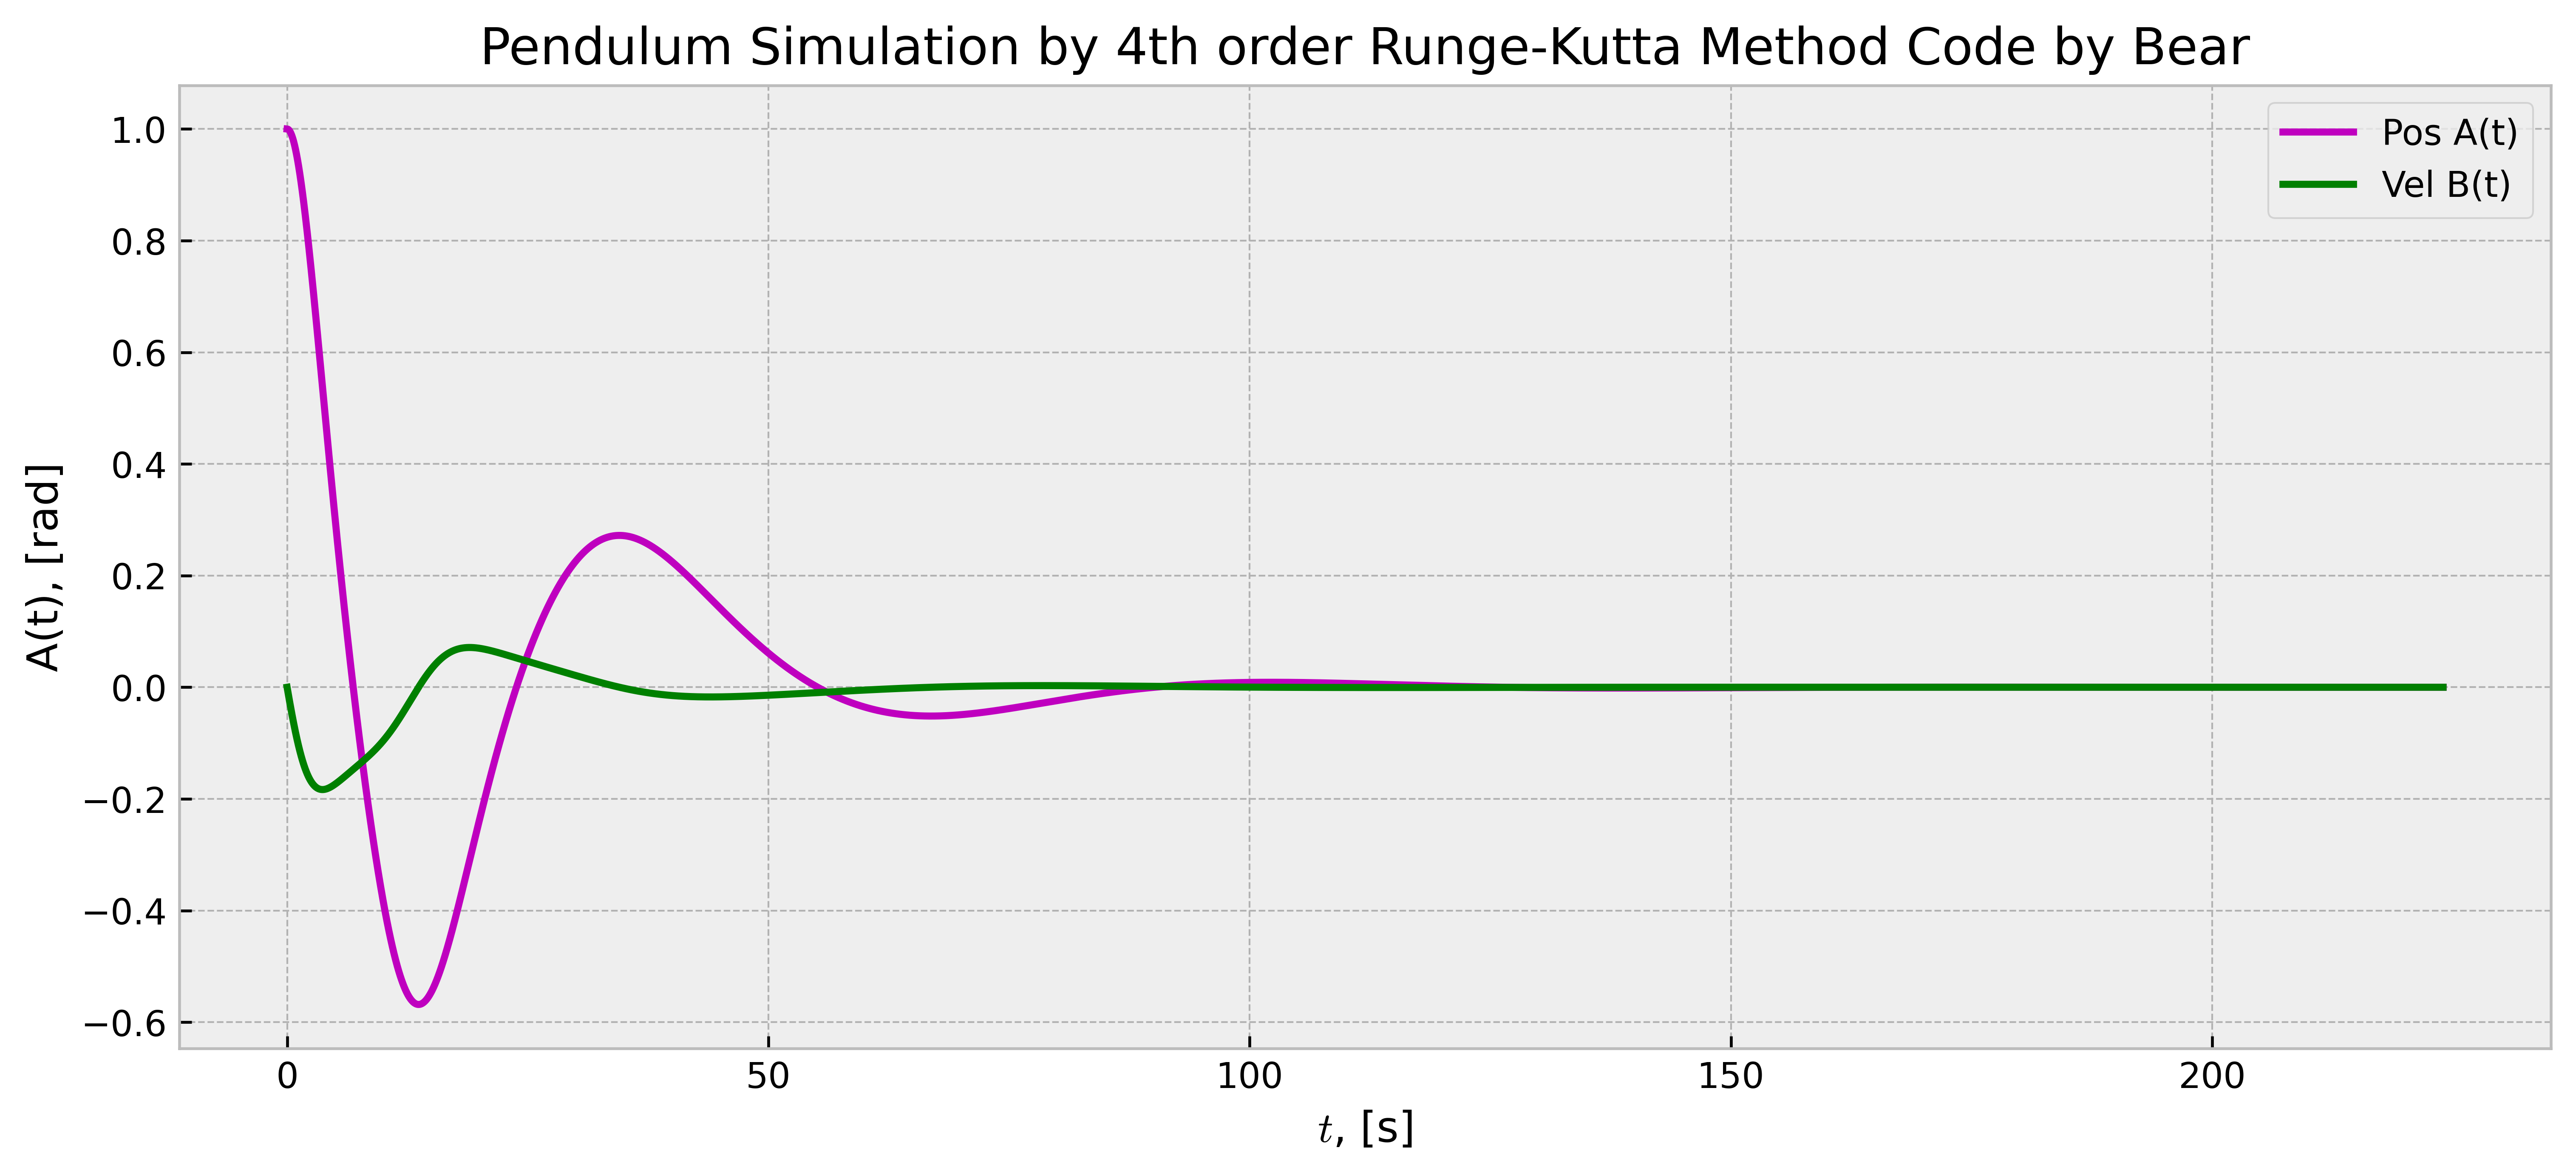

In [42]:
PB=P4LB(g=10, A0=1, B0=0, dt=0.01, T=224, C=[[-0.1,0.01,-0.01],[0.1,0.01,-0.1],[0,0,0]])
PB.RK_LB()
PB.show()

### *补充算例：大角度阻尼振动的解法*

将需要的微分方程修改一下
<img style="float: middle;" src="ad-1.png" width="32%">

代码部分非常相似，我已经在必要的地方注释，不影响理解

In [7]:
#参数定义和说明

global L                      #m 单摆的摆长
L = 10
global g                      #m/s^2 重力加速度
g = 10
global fw                     #rad/s 摆动频率
fw = np.sqrt(g/L)


global t                      #单摆运动的时间 s
t = np.arange(0,10,0.01)
global w0                     #单摆运动的初始角速度 rad/s
w0 = 0
global W                      #单摆运动的角速度集合 rad/s
W = [w0]
global a0                     #单摆的摆动初始角度 rad
a0 = (5/180)*np.pi
global A                      #单摆的摆动角度集合 rad
A = [a0]

global u
# u就是微分方程中的阻尼常数项，严格来讲这个项应该和质量大小有关系，但因为质量也是常数，我们可以直接把这些常数合并在一起
u = 1

#先定义初始函数，这里dwl就是指的w与θ的关系式（由于程序中θ字母不方便使用，这里都用a来代替θ）
#由于阻尼的影响，方程右边增加了非线性和大角度的相关项，所以需要进行修改，这里把函数改成dwlf
# code by bear

def dwlf(a,w,_t):
    _res=  -g *  np.sin(a)  / L - u * w / L
    return _res

#定义RK函数,为了区别，这里用RK_3来区别和单摆模拟算法

def RK_LF(A0,W0,dt,T=10):
    
    #时间数组
    _t=np.arange(dt,T,dt)
    
    #初始条件，（时间，振幅，角速度）
    T = [0]
    A = [A0]
    W = [W0]
    
    #结果数组，反馈的结果都在这个数组里面，其中第一项是时间，第二项是振幅，第三项是角速度
    Res = [[0,A0,W0]]

    #利用四阶龙格-库塔法，依次对函数进行数值解析
    
    for i in _t:
        
        #函数初始值
        _w=W[-1]
        _a=A[-1]
        
        #步长的计算过程，由于是二阶方程，所以用了两次，总共8个步长常数
        #这里修改了函数，将dw改为dwf
        k11 = _w
        k21 = dwlf(_a,_w,i)
        k12 = _w + 0.5 * dt * k21
        k22 = dwlf(_a + 0.5 * dt * k11, _w + 0.5 * dt * k21, 0.5 * dt)
        k13 = _w + 0.5 * dt *k22
        k23 = dwlf(_a + 0.5 * dt * k12, _w + 0.5 * dt * k22, 0.5 * dt)
        k14 = _w + dt * k23
        k24 = dwlf(_a + dt * k13, _w + dt * k23, 0.5 * dt)

        #步长的累计结果
        _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
        _W = _w + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
        #保存过程数据，方便画图
        A.append(_A)
        W.append(_W)
        Res.append([i,_A,_W])
        
    #数组整合成向量，方便输出和后续数据处理
    Res=np.array(Res)
    return Res

In [8]:
#设计运算
u=1
a0 = (5/180)*np.pi
Res=RK_LF(a0,w0,0.01,22)
T_LF=Res[:,0]
A_LF=Res[:,1]
W_LF=Res[:,2]

将结果作出图像，这里先不进行对比

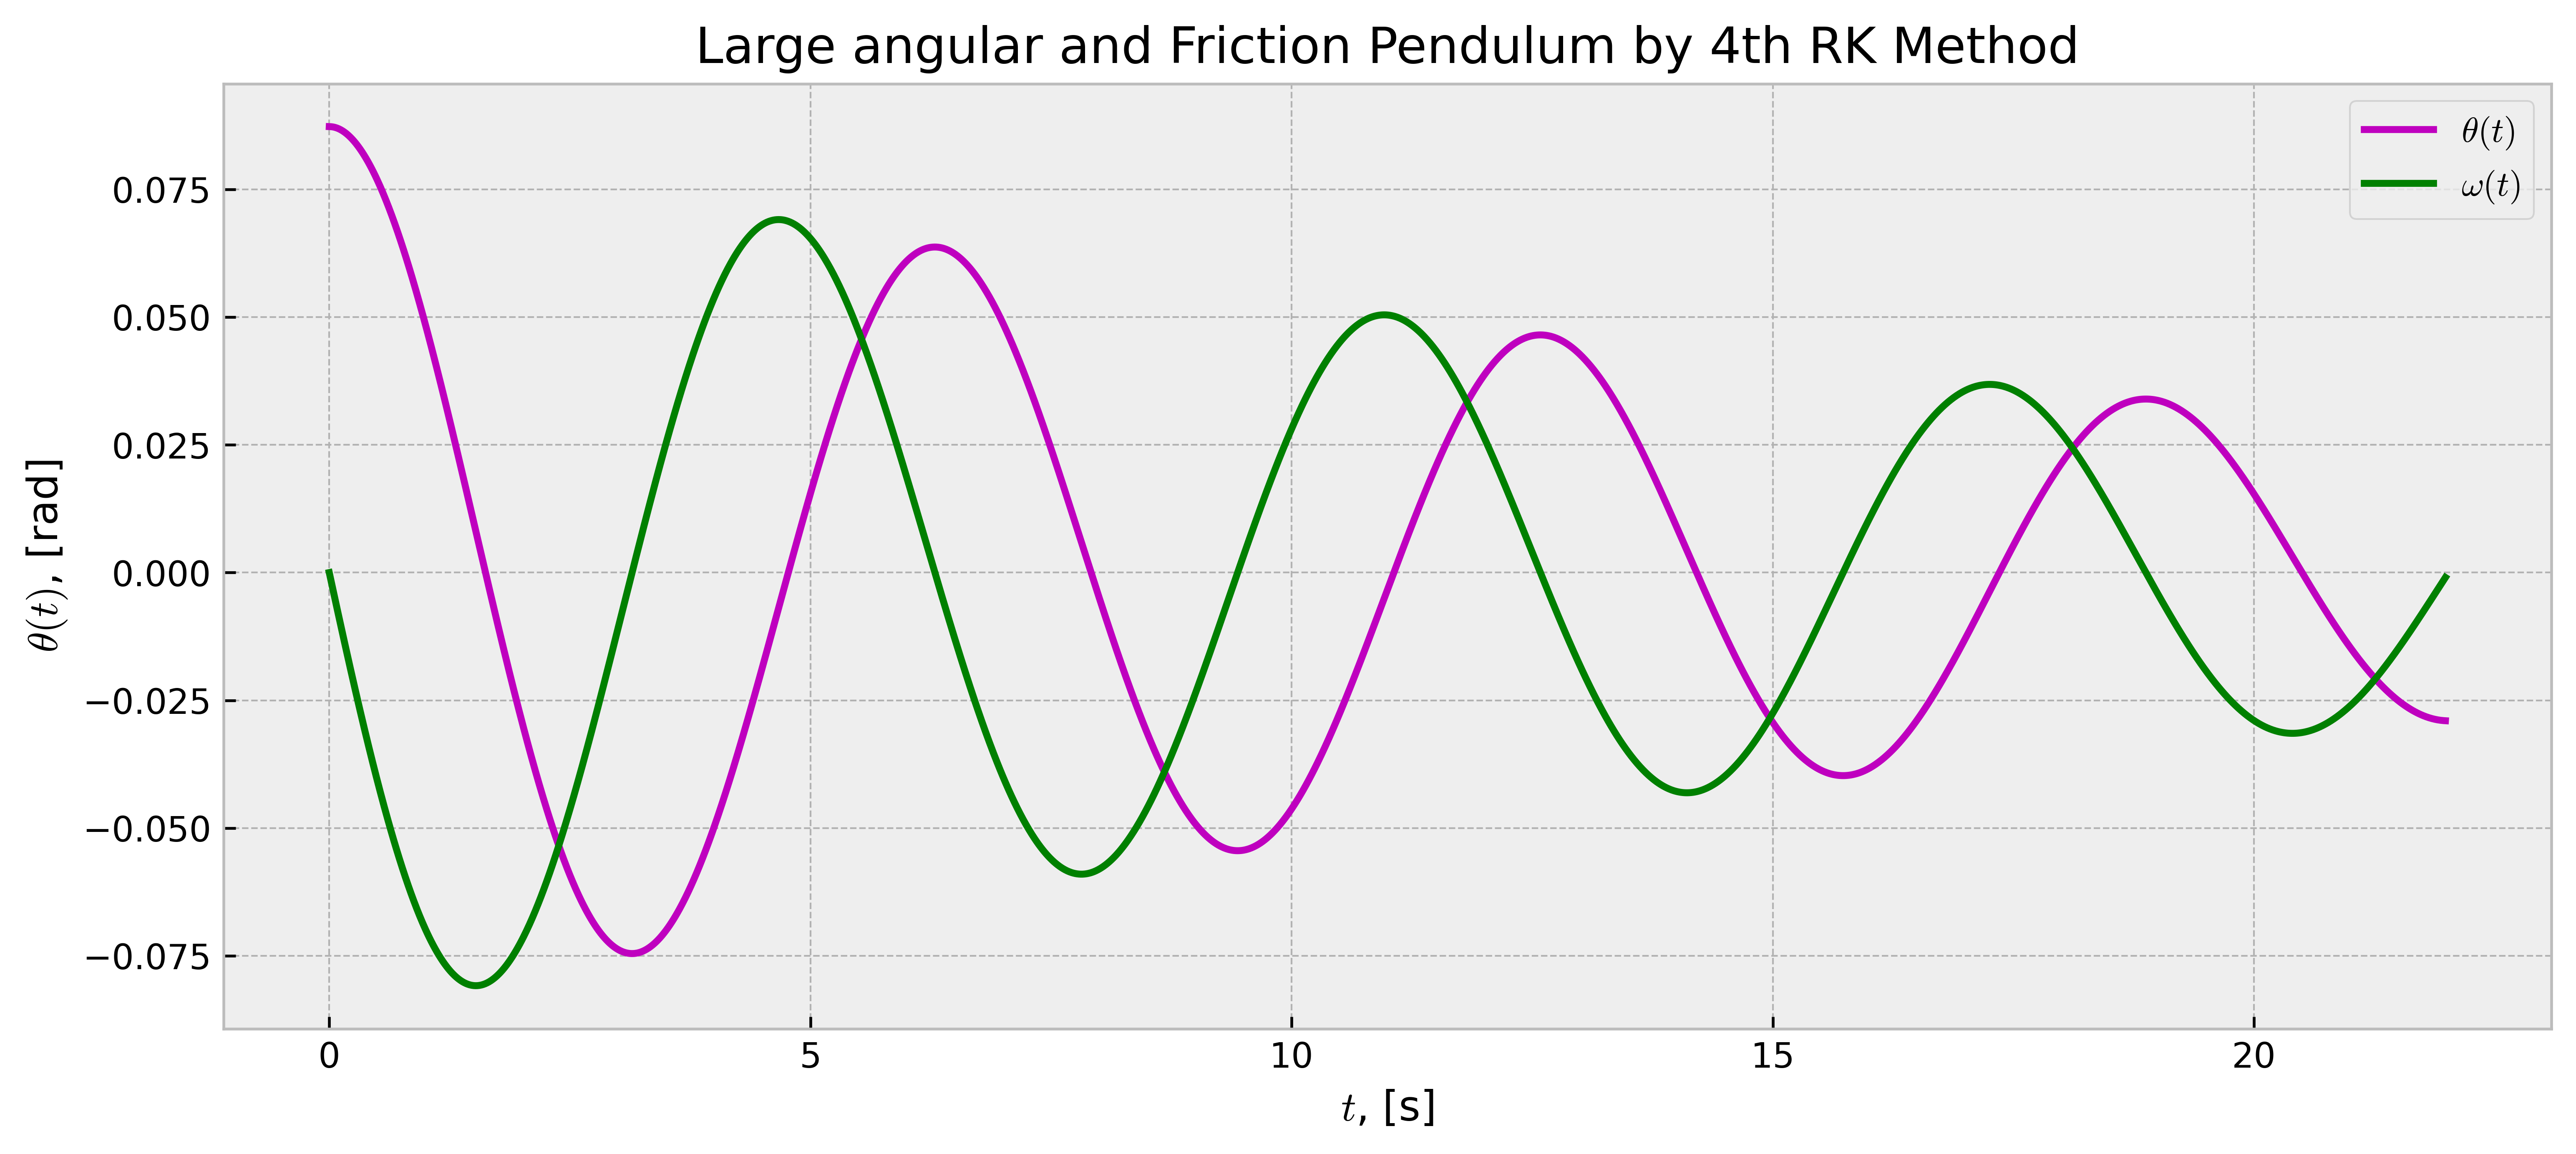

In [10]:
plt.figure(figsize=figsize, dpi=dpi)
plt.title("Large angular and Friction Pendulum by 4th RK Method")
plt.plot(T_LF, A_LF, "m", label=r"$\theta(t)$")
plt.plot(T_LF, W_LF, "g", label=r"$\omega(t)$")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

先进行大角度单摆和阻尼单摆的分别对比

In [11]:
#先定义初始函数，这里dwl就是指的w与θ的关系式（由于程序中θ字母不方便使用，这里都用a来代替θ）
#由于阻尼的影响，方程右边增加了角速度的相关项，所以需要进行修改，这里把函数改成dwf
# code by bear

def dwf(a,w,_t):
    return ( -g * a / L - u * w / L)

#定义RK函数,为了区别，这里用RK_3来区别和单摆模拟算法

def RK_3(A0,W0,dt,T=10):
    
    #时间数组
    _t=np.arange(dt,T,dt)
    
    #初始条件，（时间，振幅，角速度）
    T = [0]
    A = [A0]
    W = [W0]
    
    #结果数组，反馈的结果都在这个数组里面，其中第一项是时间，第二项是振幅，第三项是角速度
    Res = [[0,A0,W0]]

    #利用四阶龙格-库塔法，依次对函数进行数值解析
    
    for i in _t:
        
        #函数初始值
        _w=W[-1]
        _a=A[-1]
        
        #步长的计算过程，由于是二阶方程，所以用了两次，总共8个步长常数
        #这里修改了函数，将dw改为dwf
        k11 = _w
        k21 = dwf(_a,_w,i)
        k12 = _w + 0.5 * dt * k21
        k22 = dwf(_a + 0.5 * dt * k11, _w + 0.5 * dt * k21, 0.5 * dt)
        k13 = _w + 0.5 * dt *k22
        k23 = dwf(_a + 0.5 * dt * k12, _w + 0.5 * dt * k22, 0.5 * dt)
        k14 = _w + dt * k23
        k24 = dwf(_a + dt * k13, _w + dt * k23, 0.5 * dt)

        #步长的累计结果
        _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
        _W = _w + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
        #保存过程数据，方便画图
        A.append(_A)
        W.append(_W)
        Res.append([i,_A,_W])
        
    #数组整合成向量，方便输出和后续数据处理
    Res=np.array(Res)
    return Res


#先定义初始函数，这里dwl就是指的w与θ的关系式（由于程序中θ字母不方便使用，这里都用a来代替θ）
#首先，dwl的函数有变化，和dw不同这里需要改变a的算法形式为下
# code by bear

def dwl(a,w,_t):
    return ( -g * np.sin(a) / L )

#定义RK函数,为了区别，这里用RK_2来区别和单摆模拟算法

def RK_2(A0,W0,dt,T=10):
    
    #时间数组
    _t=np.arange(dt,T,dt)
    
    #初始条件，（时间，振幅，角速度）
    T = [0]
    A = [A0]
    W = [W0]
    
    #结果数组，反馈的结果都在这个数组里面，其中第一项是时间，第二项是振幅，第三项是角速度
    Res = [[0,A0,W0]]

    #利用四阶龙格-库塔法，依次对函数进行数值解析
    
    for i in _t:
        
        #函数初始值
        _w=W[-1]
        _a=A[-1]
        
        #步长的计算过程，由于是二阶方程，所以用了两次，总共8个步长常数
        #这里修改了函数，将dw改为dwl
        k11 = _w
        k21 = dwl(_a,_w,i)
        k12 = _w + 0.5 * dt * k21
        k22 = dwl(_a + 0.5 * dt * k11, _w + 0.5 * dt * k21, 0.5 * dt)
        k13 = _w + 0.5 * dt *k22
        k23 = dwl(_a + 0.5 * dt * k12, _w + 0.5 * dt * k22, 0.5 * dt)
        k14 = _w + dt * k23
        k24 = dwl(_a + dt * k13, _w + dt * k23, 0.5 * dt)

        #步长的累计结果
        _A = _a + (dt / 6.0)*(k11 + 2 * k12 + 2 * k13 + k14)
        _W = _w + (dt / 6.0)*(k21 + 2 * k22 + 2 * k23 + k24)
        
        #保存过程数据，方便画图
        A.append(_A)
        W.append(_W)
        Res.append([i,_A,_W])
        
    #数组整合成向量，方便输出和后续数据处理
    Res=np.array(Res)
    return Res

In [12]:
#设计运算 参数设计稍微合理一点
u=2
a0 = (90/180)*np.pi

#大角度阻尼函数的结果
Res=RK_LF(a0,w0,0.01,22)
T_LF=Res[:,0]
A_LF=Res[:,1]
W_LF=Res[:,2]

#大角度函数结果
Res=RK_2(a0,w0,0.01,22)
T_L=Res[:,0]
A_L=Res[:,1]
W_L=Res[:,2]

#阻尼函数的结果
Res=RK_3(a0,w0,0.01,22)
T_F=Res[:,0]
A_F=Res[:,1]
W_F=Res[:,2]

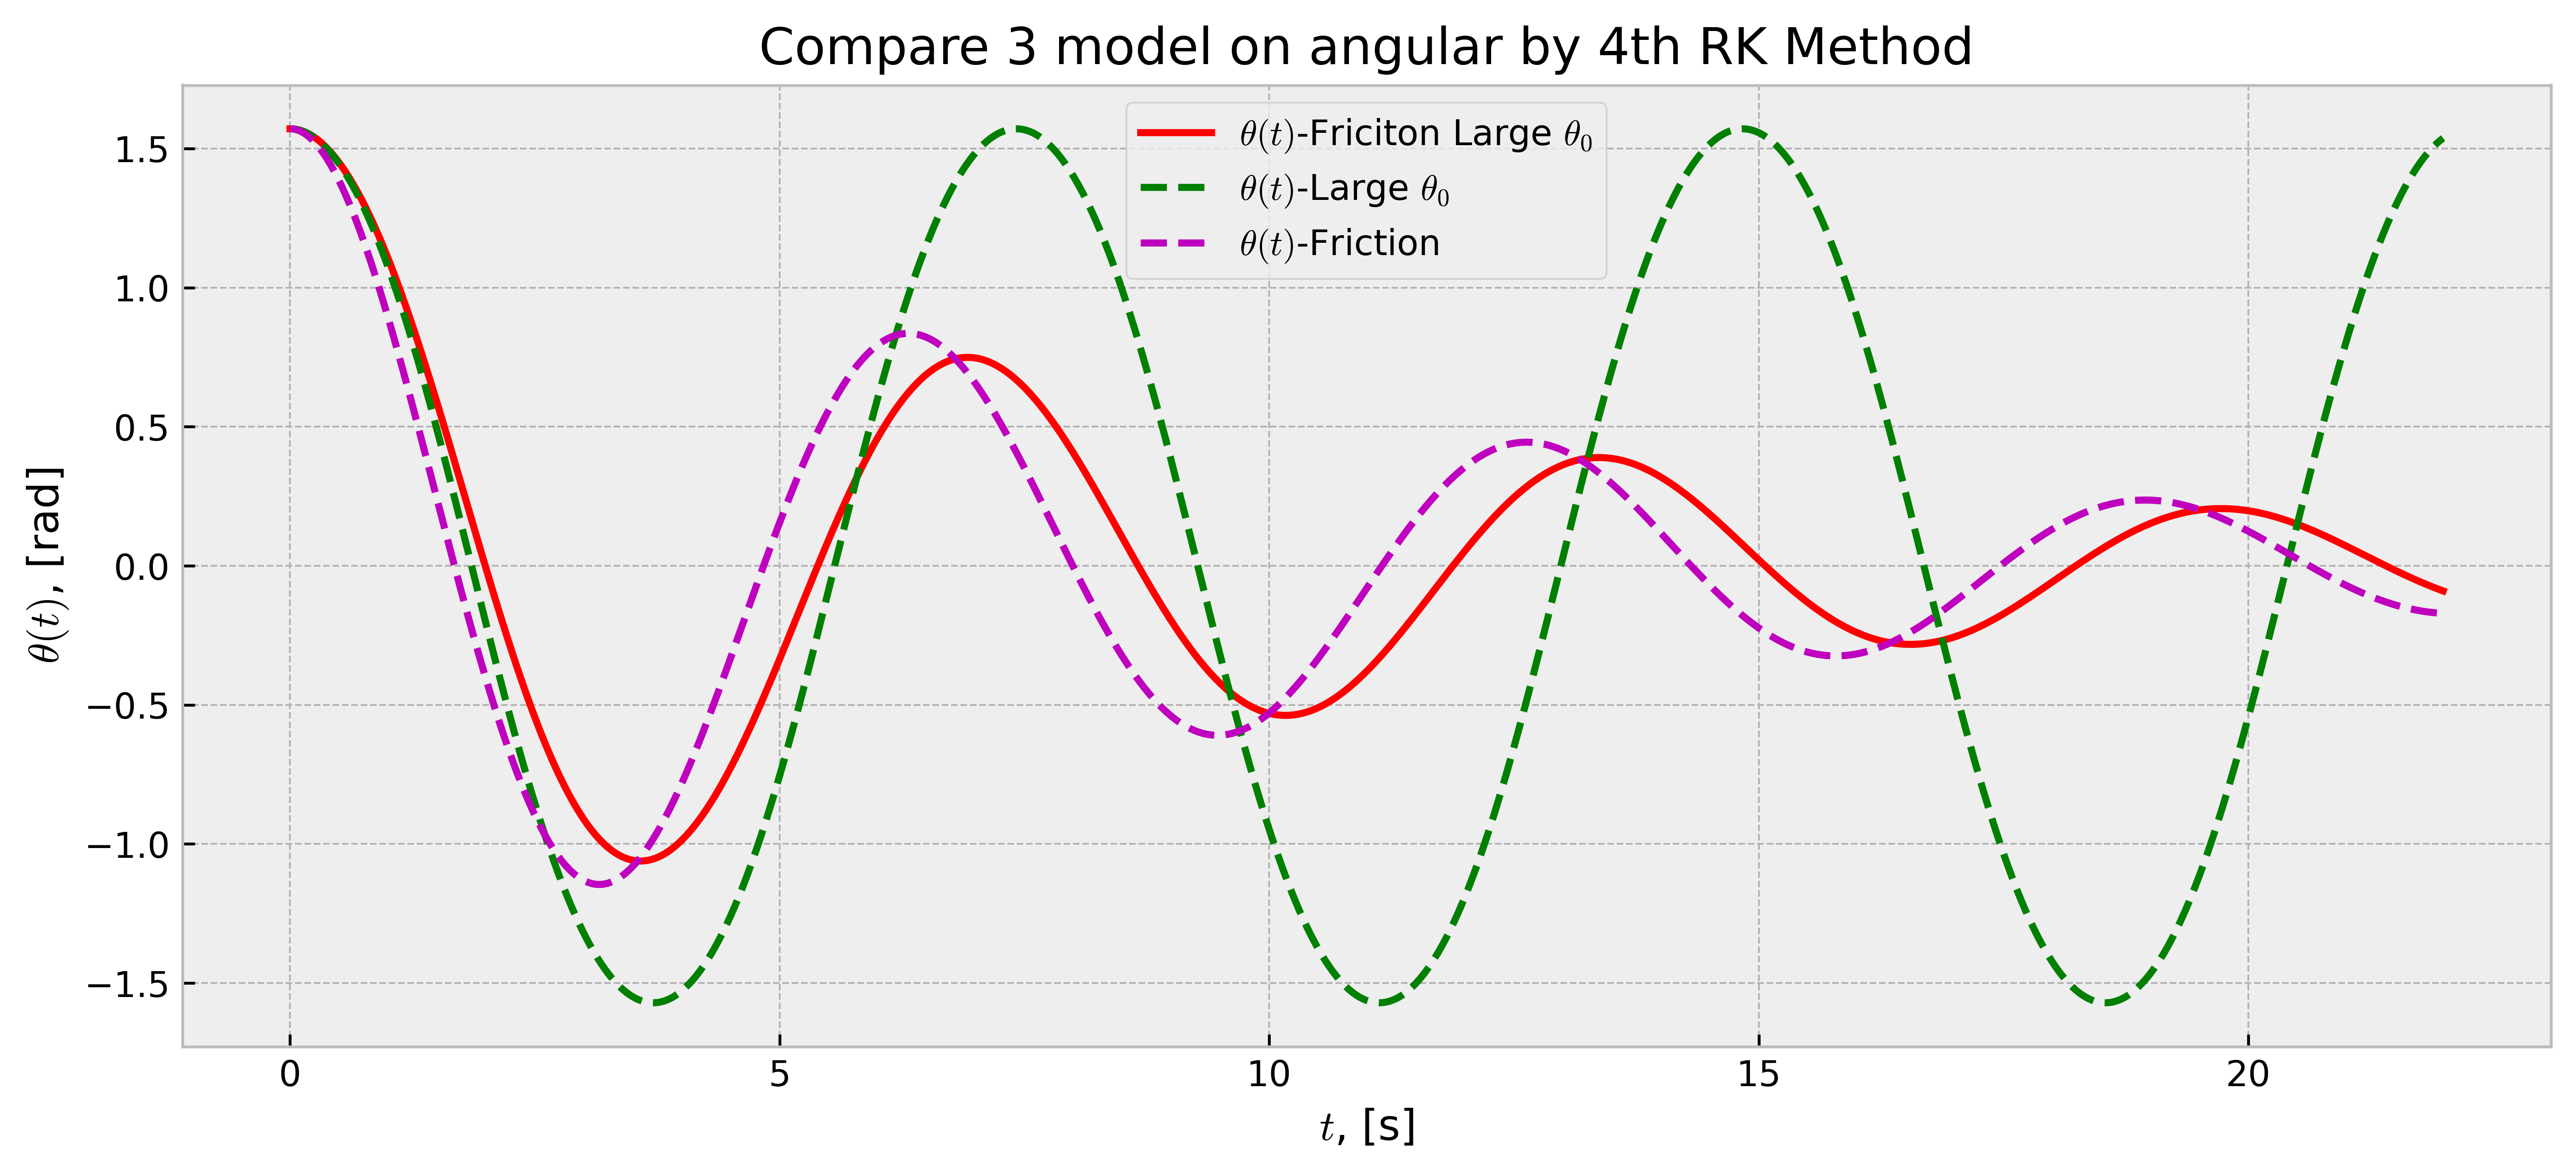

In [24]:
plt.figure(figsize=figsize, dpi=dpi)
plt.title("Compare 3 model on angular by 4th RK Method")
plt.plot(T_LF, A_LF, "r", label=r"$\theta(t)$-Friciton Large $\theta_0$")
plt.plot(T_LF, A_L, "g--", label=r"$\theta(t)$-Large $\theta_0$")
plt.plot(T_LF, A_F, "m--", label=r"$\theta(t)$-Friction")
plt.xlabel(r"$t$, [s]")
plt.ylabel(r"$\theta(t)$, [rad]")
plt.legend()
plt.show()

可以看到，与另外两个模型对比，这个模型对实际方程的拟合更加接近真实情况